# Tensorflow Recommenders - An Implementation on Retail Data

Objective: To demonstrate TensorFlow 2.0 TFRS recommenders library to build a recommendation system on a customer retail data.

Data source: https://www.kaggle.com/olistbr/brazilian-ecommerce/home/

Benefit: Flexible model, ability to add different features and specify and adjust model complexity easily.

Two types of recommendation model-- Retrieval and Ranking.

Retrieval: The retrieval stage is responsible for selecting an initial set of hundreds of candidates from all possible candidates. The main objective of this model is to efficiently weed out all candidates that the user is not interested in. Because the retrieval model may be dealing with millions of candidates, it has to be computationally efficient.
Retrieval can be computationally more efficient because it only returns smaller set of items a user would strongly interested.

Ranking: The ranking stage takes the outputs of the retrieval model and fine-tunes them to select the best possible handful of recommendations. Its task is to narrow down the set of items the user may be interested in to a shortlist of likely candidates.

# Tensorflow recommenders

Tensorflow recommders work akin to a hybrid recommendation system, where it combines the interactions in between users and items, alongside any features available of both, in a matrix dot product. The content of both sides of equation are embed in layers of what they called a tower model, where they stack these information, learn about them separately, and combine them for learning and loss propagation.

# Pros and cons

Pros:
- flexibility to add features
- flexiblity to tune models
- with decent knowledge of Tensorflow, users can expand the layers of deep learning to create a complex engine

Cons:
- Further developement needed to scale up towards sparse data
 - strict data requirement, not-user friendly
 

## Basic Retrieval Model

Load the data. It has been cleaned before, so here is the cleaned and merged table

In [1]:
### Import necessary libraries

from typing import Dict, Text

import numpy as np
import tensorflow as tf

import tensorflow_recommenders as tfrs

import os
import pprint
import tempfile

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
masterdf = pd.read_csv('../data_cleaned/brazildata_mod.csv')
masterdf.head(3)

,Unnamed: 0,order_id,order_purchase_timestamp,user_id,customer_city,customer_state,product_category,quantity,price,review_score,timestamp,product_code,product_id
0,0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,9ef432eb6251297304e76186b10a928d,sao paulo,SP,housewares,1.0,29.99,4,1.506942e+09,87285b34884572647811a353c7ac498a,housewares SKU 0
1,1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,b0830fb4747a6c6d20dea0b8c802d7ef,barreiras,BA,perfumery,1.0,118.70,4,1.532465e+09,595fac2a385ac33a80bd5114aec74eb8,perfumery SKU 0
2,2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,41ce2a54c0b03bf3443c3d931a367089,vianopolis,GO,auto,1.0,159.90,5,1.533718e+09,aa4383b373c6aca5d8797843e5594415,auto SKU 0


In [5]:
masterdf[['order_id', 'timestamp', 'user_id',
       'customer_city', 'product_category','product_id', 'quantity',
       'price', 'review_score' ]]

,order_id,timestamp,user_id,customer_city,product_category,product_id,quantity,price,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,1.506942e+09,9ef432eb6251297304e76186b10a928d,sao paulo,housewares,housewares SKU 0,1.0,29.99,4
1,53cdb2fc8bc7dce0b6741e2150273451,1.532465e+09,b0830fb4747a6c6d20dea0b8c802d7ef,barreiras,perfumery,perfumery SKU 0,1.0,118.70,4
2,47770eb9100c2d0c44946d9cf07ec65d,1.533718e+09,41ce2a54c0b03bf3443c3d931a367089,vianopolis,auto,auto SKU 0,1.0,159.90,5
3,949d5b44dbf5de918fe9c16f97b45f8a,1.511033e+09,f88197465ea7920adcdbec7375364d82,sao goncalo do amarante,pet_shop,pet_shop SKU 0,1.0,45.00,5
4,ad21c59c0840e6cb83a9ceb5573f8159,1.518557e+09,8ab97904e6daea8866dbdbc4fb7aad2c,santo andre,stationery,stationery SKU 0,1.0,19.90,5
...,...,...,...,...,...,...,...,...,...
82592,aa04ef5214580b06b10e2a378300db44,1.485477e+09,f01a6bfcc730456317e4081fe0c9940e,divinopolis,health_beauty,health_beauty SKU 100,1.0,370.00,5
82593,63943bddc261676b46f01ca7ac2f7bd8,1.517922e+09,1fca14ff2861355f6e5f14306ff977a7,praia grande,baby,baby SKU 12,1.0,174.90,4
82594,83c1379a015df1e13d02aae0204711ab,1.503845e+09,1aa71eb042121263aafbe80c1b562c9c,nova vicosa,home_appliances_2,home_appliances_2 SKU 58,1.0,205.99,5
82595,11c177c8e97725db2631073c19f07b62,1.515447e+09,b331b74b18dc79bcdf6532d51e1637c1,japuiba,computers_accessories,computers_accessories SKU 2,1.0,179.99,2


# Idenfity features that we need, and prepare the dataset

The data contains many usable features, notably customer geographical area and product category. Users who are familar with content-based recommendation or hybrid recommendation system know that additional features of users and items help to improve the accuracy of the prediction.

Let us start with user id, product id, and quantity. These three features are the bare minimum of what the engine needs. Think of quantity as equivalent to ratings in movie recommendation system, where the quantity tells us how much the consumer likes to buy the item, the higher the quantity, the higher his/her preference.

In [8]:
### standardize item data types, especially string, float, and integer

masterdf[['user_id',      
          'product_id',  
         ]] = masterdf[['user_id','product_id']].astype(str)

# we will play around with the data type of the quantity, 
# which you shall see later it affects the accuracy of the prediction.

masterdf['quantity'] = masterdf['quantity'].astype(float)

#### Data Preparation - Query and candidate table

We only need to prepare two set of reference table-- an item table, which will be the ultimate reference table for items to be recommended, and an interaction/query table (or a ranking table, in the case of IMDB movie example) where it shows user's previous purchase history.

In [35]:
### define interactions data and user data

### interactions 
### here we create a reference table of the user , item, and quantity purchased
interactions_dict = masterdf.groupby(['user_id', 'product_id'])[ 'quantity'].sum().reset_index()

## we tansform the table inta a dictionary , which then we feed into tensor slices
# this step is crucial as this will be the type of data fed into the embedding layers
interactions_dict = {name: np.array(value) for name, value in interactions_dict.items()}
interactions = tf.data.Dataset.from_tensor_slices(interactions_dict)

## we do similar step for item, where this is the reference table for items to be recommended
items_dict = masterdf[['product_id']].drop_duplicates()
items_dict = {name: np.array(value) for name, value in items_dict.items()}
items = tf.data.Dataset.from_tensor_slices(items_dict)

## map the features in interactions and items to an identifier that we will use throught the embedding layers
## do it for all the items in interaction and item table
## you may often get itemtype error, so that is why here i am casting the quantity type as float to ensure consistency
interactions = interactions.map(lambda x: {
    'user_id' : x['user_id'], 
    'product_id' : x['product_id'], 
    'quantity' : float(x['quantity']),

})

items = items.map(lambda x: x['product_id'])

#### Basic Housekeeping

Let's also figure out unique user ids and movie titles present in the data.

We need a reference map of the raw values of categorical features to embedding vectors in the retrieval models. To do that, we need a vocabulary that maps a raw feature value to an integer in a contiguous range, which then will be mapped to the corresponding embeddings in the embedding tables inside the model.

In [36]:
unique_item_titles = np.unique(np.concatenate(list(items.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(interactions.batch(1_000).map(lambda x: x["user_id"]))))

In [48]:
### get unique item and user id's as a lookup table
unique_item_titles = np.unique(np.concatenate(list(items.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(interactions.batch(1_000).map(lambda x: x["user_id"]))))

# Randomly shuffle data and split between train and test.
tf.random.set_seed(42)
shuffled = interactions.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(60_000)
test = shuffled.skip(60_000).take(20_000)

# Ranking and Retrieval

#### Simple Retrieval Model

There are five important component of the query and candicate tower: candidate model (item_model), querty model (user_model), metrics, task, and compute loss. I will explain each of them in the model below:

In [38]:
class RetailModel(tfrs.Model):

    def __init__(self, user_model, item_model):
        super().__init__()
        
        ### Candidate model (item)
        ### This is Keras preprocessing layers to first convert user ids to integers, 
        ### and then convert those to user embeddings via an Embedding layer. 
        ### We use the list of unique user ids we computed earlier as a vocabulary:
        item_model = tf.keras.Sequential([
                                        tf.keras.layers.experimental.preprocessing.StringLookup(
                                        vocabulary=unique_item_titles, mask_token=None),
                                        tf.keras.layers.Embedding(len(unique_item_titles) + 1, embedding_dimension)
                                        ])
        ### we pass the embedding layer into item model
        self.item_model: tf.keras.Model = item_model
            
        ### Query model (users)    
        user_model = tf.keras.Sequential([
                                        tf.keras.layers.experimental.preprocessing.StringLookup(
                                        vocabulary=unique_user_ids, mask_token=None),
                                        # We add an additional embedding to account for unknown tokens.
                                        tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
                                        ])
        self.user_model: tf.keras.Model = user_model
        
        ### for retrieval model. we take top-k accuracy as metrics
        metrics = tfrs.metrics.FactorizedTopK(
                                            candidates=items.batch(128).map(item_model)
        
        # define the task, which is retrieval                                    )    
        task = tfrs.tasks.Retrieval(
                                    metrics=metrics
                                    )
       
        self.task: tf.keras.layers.Layer = task

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        # We pick out the user features and pass them into the user model.
        user_embeddings = self.user_model(features["user_id"])
        # And pick out the movie features and pass them into the movie model,
        # getting embeddings back.
        positive_movie_embeddings = self.item_model(features["product_id"])

        # The task computes the loss and the metrics.
        return self.task(user_embeddings, positive_movie_embeddings)

#### Fitting and evaluating

In [49]:
### Fitting and evaluating

### we choose the dimensionality of the query and candicate representation.
embedding_dimension = 32

## we pass the model, which is the same model we created in the query and candidate tower, into the model
item_model = tf.keras.Sequential([
                                tf.keras.layers.experimental.preprocessing.StringLookup(
                                vocabulary=unique_item_titles, mask_token=None),
                                tf.keras.layers.Embedding(len(unique_item_titles) + 1, embedding_dimension)
                                ])

user_model = tf.keras.Sequential([
                                tf.keras.layers.experimental.preprocessing.StringLookup(
                                vocabulary=unique_user_ids, mask_token=None),
                                # We add an additional embedding to account for unknown tokens.
                                tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
                                ])

model = RetailModel(user_model, item_model)

# a smaller learning rate may make the model move slower and prone to overfitting, so we stick to 0.1
# other optimizers, such as SGD and Adam, are listed here https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

## fit the model with ten epochs
model_hist = model.fit(cached_train, epochs=10)

#evaluate the model
model.evaluate(cached_test, return_dict=True)

Epoch 1/10
8/8 [==============================] - 13s 1s/step - factorized_top_k/top_1_categorical_accuracy: 0.0013 - factorized_top_k/top_5_categorical_accuracy: 0.0047 - factorized_top_k/top_10_categorical_accuracy: 0.0074 - factorized_top_k/top_50_categorical_accuracy: 0.0192 - factorized_top_k/top_100_categorical_accuracy: 0.0291 - loss: 62067.3594 - regularization_loss: 0.0000e+00 - total_loss: 62067.3594
Epoch 2/10
8/8 [==============================] - 11s 1s/step - factorized_top_k/top_1_categorical_accuracy: 0.0873 - factorized_top_k/top_5_categorical_accuracy: 0.1983 - factorized_top_k/top_10_categorical_accuracy: 0.2584 - factorized_top_k/top_50_categorical_accuracy: 0.4776 - factorized_top_k/top_100_categorical_accuracy: 0.6039 - loss: 61768.0087 - regularization_loss: 0.0000e+00 - total_loss: 61768.0087
Epoch 3/10
8/8 [==============================] - 11s 1s/step - factorized_top_k/top_1_categorical_accuracy: 0.2200 - factorized_top_k/top_5_categorical_accuracy: 0.3801 - 

In [50]:
model.evaluate(cached_test, return_dict=True)

4/4 [==============================] - 6s 940ms/step - factorized_top_k/top_1_categorical_accuracy: 4.6207e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0041 - factorized_top_k/top_10_categorical_accuracy: 0.0065 - factorized_top_k/top_50_categorical_accuracy: 0.0208 - factorized_top_k/top_100_categorical_accuracy: 0.0337 - loss: 22440.4807 - regularization_loss: 0.0000e+00 - total_loss: 22440.4807


{'factorized_top_k/top_1_categorical_accuracy': 0.0004620716208592057,
 'factorized_top_k/top_5_categorical_accuracy': 0.004081632476300001,
 'factorized_top_k/top_10_categorical_accuracy': 0.006469002924859524,
 'factorized_top_k/top_50_categorical_accuracy': 0.02079322375357151,
 'factorized_top_k/top_100_categorical_accuracy': 0.033654216676950455,
 'loss': 4584.71142578125,
 'regularization_loss': 0,
 'total_loss': 4584.71142578125}

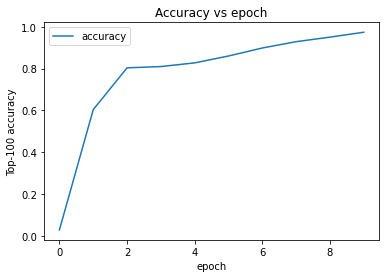

In [52]:
# num_validation_runs = len(one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [i for i in range(10)]

plt.plot(epochs, model_hist.history["factorized_top_k/top_100_categorical_accuracy"], label="accuracy")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

Notice that accuracy is pretty bad, but if we plot the number of accuracy vs epoch, we can see that it improves higher as more iterations go through.

To predict top recommended items for specific users, say, here, user 40, we use brute force layers take considers all available items for them. To speed up the calculation, refer to efficient serving: https://www.tensorflow.org/recommenders/examples/efficient_serving

In [53]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends movies out of the entire movies dataset.
index.index(items.batch(100).map(model.item_model), items)

# Get recommendations.
j = str(40)
_, titles = index(tf.constant([j]))
print(f"Recommendations for user %s: {titles[0]}" %(j))

Recommendations for user 40: [b'pet_shop SKU 25' b'cool_stuff SKU 25' b'bed_bath_table SKU 520'
 b'costruction_tools_tools SKU 1' b'bed_bath_table SKU 252'
 b'bed_bath_table SKU 230' b'computers_accessories SKU 127'
 b'furniture_decor SKU 87' b'watches_gifts SKU 265' b'electronics SKU 68']


There you are, our first simple yet effective recommendation engine using retrieval task. But what about ranking? can we rank all the items for best to worst, only then run retrieval task to retrieve selected items from the short list? Now we can explore another type of recommendation task: ranking.